In [1]:
# Imports
import sys
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Setup paths
PROJECT_ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

from analysis.load_data import load_dataset
from analysis.config.model_config import FORECASTING_CONFIG
from analysis.forecasting.forecasting_utils import *

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


In [2]:
# Load Reddit Data
reddit_df = load_dataset('reddit')

print(f"Total posts: {len(reddit_df):,}")
print(f"Columns: {list(reddit_df.columns)}")
print(f"Date range: {reddit_df['DATE'].min()} to {reddit_df['DATE'].max()}")

# Calculate data span
date_range = (reddit_df['DATE'].max() - reddit_df['DATE'].min()).days
print(f"Days of data: {date_range}")
print(f"Weeks of data: {date_range / 7:.1f}")

# Check for nulls
print(f"\nData Quality:")
print(f"  Null TEXT values: {reddit_df['TEXT'].isnull().sum()}")
print(f"  Null DATE values: {reddit_df['DATE'].isnull().sum()}")
print(f"  Empty TEXT values: {(reddit_df['TEXT'] == '').sum()}")

# Display sample
print(f"\nSample data:")
print(reddit_df.head(3))

INFO:botocore.credentials:Found credentials in environment variables.
INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 3.18.0, Python Version: 3.11.13, Platform: macOS-15.4.1-x86_64-i386-64bit
INFO:snowflake.connector.connection:Connecting to GLOBAL Snowflake domain
INFO:analysis.load_data:Loaded 2793 rows from reddit_extract.sql


Total posts: 2,793
Columns: ['SUBREDDIT', 'DATE', 'TITLE', 'TEXT', 'SCORE', 'COMMENTS']
Date range: 2025-07-15 to 2026-01-04
Days of data: 173
Weeks of data: 24.7

Data Quality:
  Null TEXT values: 0
  Null DATE values: 0
  Empty TEXT values: 24

Sample data:
      SUBREDDIT        DATE  \
0  mentalhealth  2025-07-16   
1  mentalhealth  2025-07-16   
2  mentalhealth  2025-07-16   

                                               TITLE  \
0                                 Wellness Wednesday   
1  Guys I want to make an online community for so...   
2                    Why do I wanna be a kid so bad?   

                                                TEXT  SCORE  COMMENTS  
0  >*“Sometimes the bravest and most important th...      1         0  
1                                 Anyone interested?     19        33  
2  I'm 17 and since i was 13 I've been wanting no...     10         7  


INFO:analysis.forecasting.forecasting_utils:  Using single-text mode
INFO:analysis.forecasting.forecasting_utils:  Sentiment column 'sentiment' added
INFO:analysis.forecasting.forecasting_utils:  Mean: -0.232, Std: 0.685



Reddit sentiment statistics:
count    2793.000000
mean       -0.231846
std         0.685327
min        -0.994600
25%        -0.875900
50%        -0.468300
75%         0.440400
max         0.999100
Name: sentiment, dtype: float64


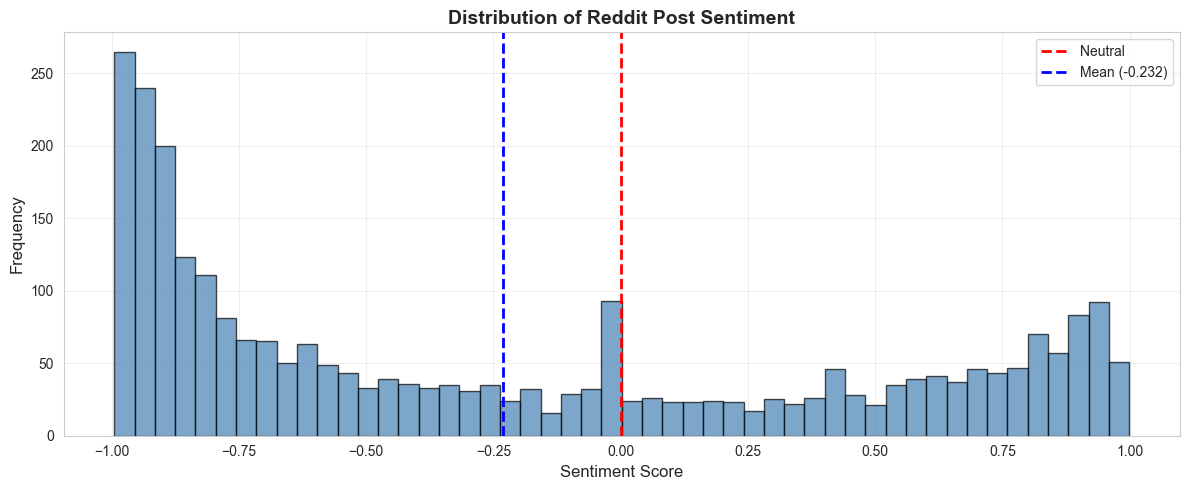


Reddit sentiment breakdown (thresholds: -0.05 to 0.05):
  Positive: 943 posts (33.8%)
  Neutral:  127 posts (4.5%)
  Negative: 1,723 posts (61.7%)


In [3]:
# Add sentiment analysis to Reddit
reddit_df = add_sentiment_column(
    df=reddit_df,
    text_column='TEXT',
    sentiment_column='sentiment',
    is_aggregated=False  # Each row is a single post
)

# Print Statistics
print(f"\nReddit sentiment statistics:")
print(reddit_df['sentiment'].describe())

# Show distribution
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(reddit_df['sentiment'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Sentiment Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Reddit Post Sentiment', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral')
ax.axvline(x=reddit_df['sentiment'].mean(), color='blue', linestyle='--', 
           linewidth=2, label=f"Mean ({reddit_df['sentiment'].mean():.3f})")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Sentiment breakdown
pos_threshold = FORECASTING_CONFIG['sentiment']['positive_threshold']
neg_threshold = FORECASTING_CONFIG['sentiment']['negative_threshold']

n_positive = (reddit_df['sentiment'] > pos_threshold).sum()
n_neutral = ((reddit_df['sentiment'] >= neg_threshold) & 
             (reddit_df['sentiment'] <= pos_threshold)).sum()
n_negative = (reddit_df['sentiment'] < neg_threshold).sum()

print(f"\nReddit sentiment breakdown (thresholds: {neg_threshold} to {pos_threshold}):")
print(f"  Positive: {n_positive:,} posts ({n_positive/len(reddit_df)*100:.1f}%)")
print(f"  Neutral:  {n_neutral:,} posts ({n_neutral/len(reddit_df)*100:.1f}%)")
print(f"  Negative: {n_negative:,} posts ({n_negative/len(reddit_df)*100:.1f}%)")

# Save plot
fig.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/reddit_sentiment_distribution.png',
    dpi=150,
    bbox_inches='tight'
)

In [4]:
# Aggregate Reddit Data by Week
weekly_reddit = aggregate_to_weekly(
    df=reddit_df,
    date_col='DATE',
    agg_dict={
        'TEXT': 'count',        # Count total posts per week
        'sentiment': 'mean',    # Average sentiment per week
        'SCORE': 'mean',        # Average Reddit score
        'COMMENTS': 'mean'      # Average comments
    }
)

# Rename for consistency
weekly_reddit.rename(columns={'TEXT': 'volume'}, inplace=True)

# Lowercase column name for consistency with other code
weekly_reddit.rename(columns={'DATE': 'date'}, inplace=True)

# Fill in missing weeks with linear interpolation
weekly_reddit = fill_missing_weeks(weekly_reddit, date_col='date')

print(f"\nFinal weekly Reddit data shape: {weekly_reddit.shape}")
print(f"Columns: {list(weekly_reddit.columns)}")
print(f"\nFirst 10 weeks:")
print(weekly_reddit[['date', 'volume', 'sentiment']].head(10))


Final weekly Reddit data shape: (25, 5)
Columns: ['date', 'volume', 'sentiment', 'SCORE', 'COMMENTS']

First 10 weeks:
        date  volume  sentiment
0 2025-07-14   145.0  -0.161285
1 2025-07-21   145.0  -0.159359
2 2025-07-28   145.0  -0.157433
3 2025-08-04   121.0   0.007056
4 2025-08-11    97.0   0.171545
5 2025-08-18    73.0   0.336033
6 2025-08-25    49.0   0.500522
7 2025-09-01    25.0   0.665011
8 2025-09-08     1.0   0.829500
9 2025-09-15   152.0  -0.179259


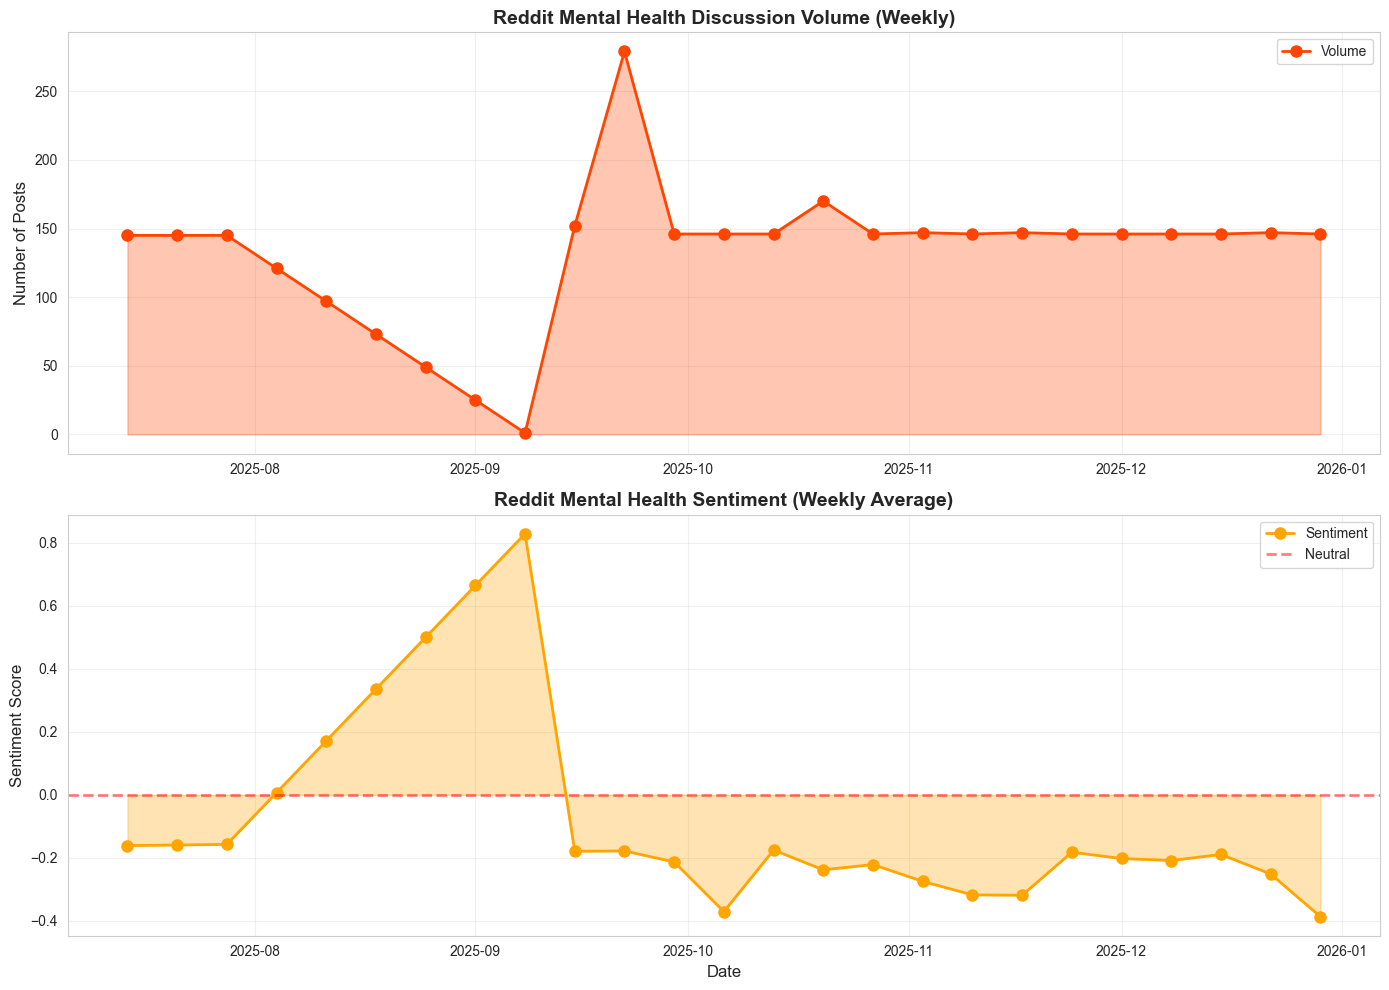

In [5]:
# Plot Reddit Volume and Sentiment
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Volume over time
ax1.plot(weekly_reddit['date'], weekly_reddit['volume'], 
         marker='o', linewidth=2, color='#FF4500', label='Volume', markersize=8)
ax1.fill_between(weekly_reddit['date'], weekly_reddit['volume'], 
                  alpha=0.3, color='#FF4500')
ax1.set_title('Reddit Mental Health Discussion Volume (Weekly)', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Posts', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Sentiment over time
ax2.plot(weekly_reddit['date'], weekly_reddit['sentiment'], 
         marker='o', linewidth=2, color='orange', label='Sentiment', markersize=8)
ax2.fill_between(weekly_reddit['date'], weekly_reddit['sentiment'], 
                  alpha=0.3, color='orange')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, 
            linewidth=2, label='Neutral')
ax2.set_title('Reddit Mental Health Sentiment (Weekly Average)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Sentiment Score', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save plot
fig.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/reddit_volume_and_sentiment.png',
    dpi=150,
    bbox_inches='tight'
)

In [6]:
# Load News data
news_df = load_dataset('news')

print(f"Total records: {len(news_df)} (already weekly aggregated)")
print(f"Columns: {list(news_df.columns)}")
print(f"\nSample data:")
print(news_df.head(3))

# Basic stats
print(f"\nDate range: {news_df['DATE'].min()} to {news_df['DATE'].max()}")
print(f"Weeks of data: {len(news_df)}")
print(f"Total articles: {news_df['ARTICLE_COUNT'].sum():,}")
print(f"Avg articles/week: {news_df['ARTICLE_COUNT'].mean():.1f}")

# Ensure DATE is datetime
news_df['DATE'] = pd.to_datetime(news_df['DATE'])

# Check delimiter
sample_headlines = str(news_df['SAMPLE_HEADLINES'].iloc[0])
print(f"Sample headlines (first 200 chars):")
print(sample_headlines[:200])

# Detect delimiter
delimiters = {';': sample_headlines.count(';'),
              '|': sample_headlines.count('|'),
              '||': sample_headlines.count('||')}
detected_delimiter = max(delimiters, key=delimiters.get)

print(f"\nDelimiter counts: {delimiters}")
print(f"Using delimiter: '{detected_delimiter}'")

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 3.18.0, Python Version: 3.11.13, Platform: macOS-15.4.1-x86_64-i386-64bit
INFO:snowflake.connector.connection:Connecting to GLOBAL Snowflake domain
INFO:analysis.load_data:Loaded 24 rows from news_extract.sql


Total records: 24 (already weekly aggregated)
Columns: ['DATE', 'ARTICLE_COUNT', 'SAMPLE_HEADLINES', 'SOURCES']

Sample data:
         DATE  ARTICLE_COUNT  \
0  2025-10-22             93   
1  2025-10-23             92   
2  2025-10-24             32   

                                    SAMPLE_HEADLINES  \
0  Mexico to Tax Mature Video Games | Pregnant IC...   
1  Villains To Be Removed at Disney Park: Will Ma...   
2  Psychologist Warns of Donald Trump’s ‘Massive ...   

                                             SOURCES  
0  NBC News, Landezine.com, Catholicnewsagency.co...  
1  Yahoo Entertainment, TheStranger.com, Rolling ...  
2  Bemorewithless.com, SFGate, New York Post, For...  

Date range: 2025-10-22 to 2026-01-03
Weeks of data: 24
Total articles: 1,268
Avg articles/week: 52.8
Sample headlines (first 200 chars):
Mexico to Tax Mature Video Games | Pregnant ICE Detainees Have Been Shackled, Forced Into Solitary Confinement | Driver Rams Vehicle into White House Gate, Taken 

In [7]:
# Add sentiment analysis to News
news_df = add_sentiment_column(
    df=news_df,
    text_column='SAMPLE_HEADLINES',
    sentiment_column='sentiment',
    is_aggregated=True,  # Each row contains multiple headlines
    delimiter=detected_delimiter
)

print(f"\nNews sentiment statistics:")
print(news_df['sentiment'].describe())

INFO:analysis.forecasting.forecasting_utils:  Using aggregated mode with delimiter '|'
INFO:analysis.forecasting.forecasting_utils:  Sentiment column 'sentiment' added
INFO:analysis.forecasting.forecasting_utils:  Mean: -0.053, Std: 0.187



News sentiment statistics:
count    24.000000
mean     -0.052752
std       0.186980
min      -0.333660
25%      -0.175450
50%      -0.047440
75%       0.058600
max       0.308140
Name: sentiment, dtype: float64


In [8]:
# Aggregate News Data by Week
weekly_news = aggregate_to_weekly(
    df=news_df,
    date_col='DATE',
    agg_dict={
        'ARTICLE_COUNT': 'sum',  # Sum articles across any runs in the week
        'sentiment': 'mean'       # Average sentiment
    }
)

# Rename for consistency
weekly_news.rename(columns={'ARTICLE_COUNT': 'volume', 'DATE': 'date'}, inplace=True)

# Fill in missing weeks with linear interpolation
date_diffs_news = weekly_news['date'].diff().dt.days.dropna()

if (date_diffs_news == 7).all():
    print("\nNews data already has perfect weekly frequency - no filling needed")
else:
    print("\nNews data has gaps - filling...")
    weekly_news = fill_missing_weeks(weekly_news, date_col='date')

# Remove first week (extreme outlier)
weekly_news = weekly_news.iloc[1:].reset_index(drop=True)

print(f"\nWeekly news data shape: {weekly_news.shape}")
print(f"Columns: {list(weekly_news.columns)}")
print(f"\nFirst 10 weeks:")
print(weekly_news.head(10))


News data already has perfect weekly frequency - no filling needed

Weekly news data shape: (10, 3)
Columns: ['date', 'volume', 'sentiment']

First 10 weeks:
        date  volume  sentiment
0 2025-10-27      96    0.00678
1 2025-11-03      94   -0.12664
2 2025-11-10      93   -0.13932
3 2025-11-17      91   -0.20172
4 2025-11-24      96   -0.05699
5 2025-12-01      95   -0.01602
6 2025-12-08      98    0.06366
7 2025-12-15      96    0.09535
8 2025-12-22      95    0.00588
9 2025-12-29     100   -0.06856


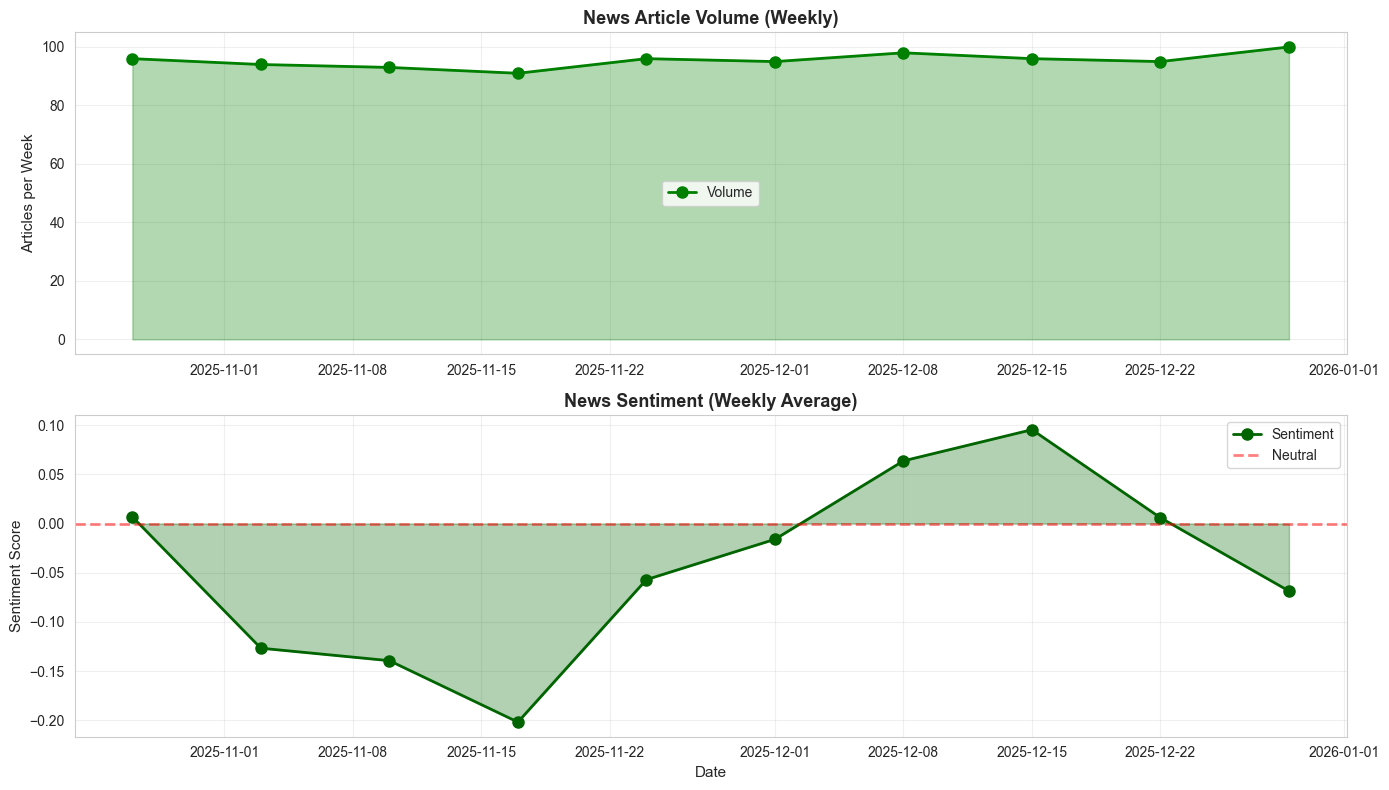

In [9]:
# Plot news volume and sentiment
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Volume
ax1.plot(weekly_news['date'], weekly_news['volume'], 
         marker='o', linewidth=2, color='green', label='Volume', markersize=8)
ax1.fill_between(weekly_news['date'], weekly_news['volume'], 
                 alpha=0.3, color='green')
ax1.set_title('News Article Volume (Weekly)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Articles per Week', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Sentiment
ax2.plot(weekly_news['date'], weekly_news['sentiment'], 
         marker='o', linewidth=2, color='darkgreen', label='Sentiment', markersize=8)
ax2.fill_between(weekly_news['date'], weekly_news['sentiment'], 
                 alpha=0.3, color='darkgreen')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Neutral')
ax2.set_title('News Sentiment (Weekly Average)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Sentiment Score', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Save plot
fig.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/news_volume_and_sentiment.png',
    dpi=150,
    bbox_inches='tight'
)

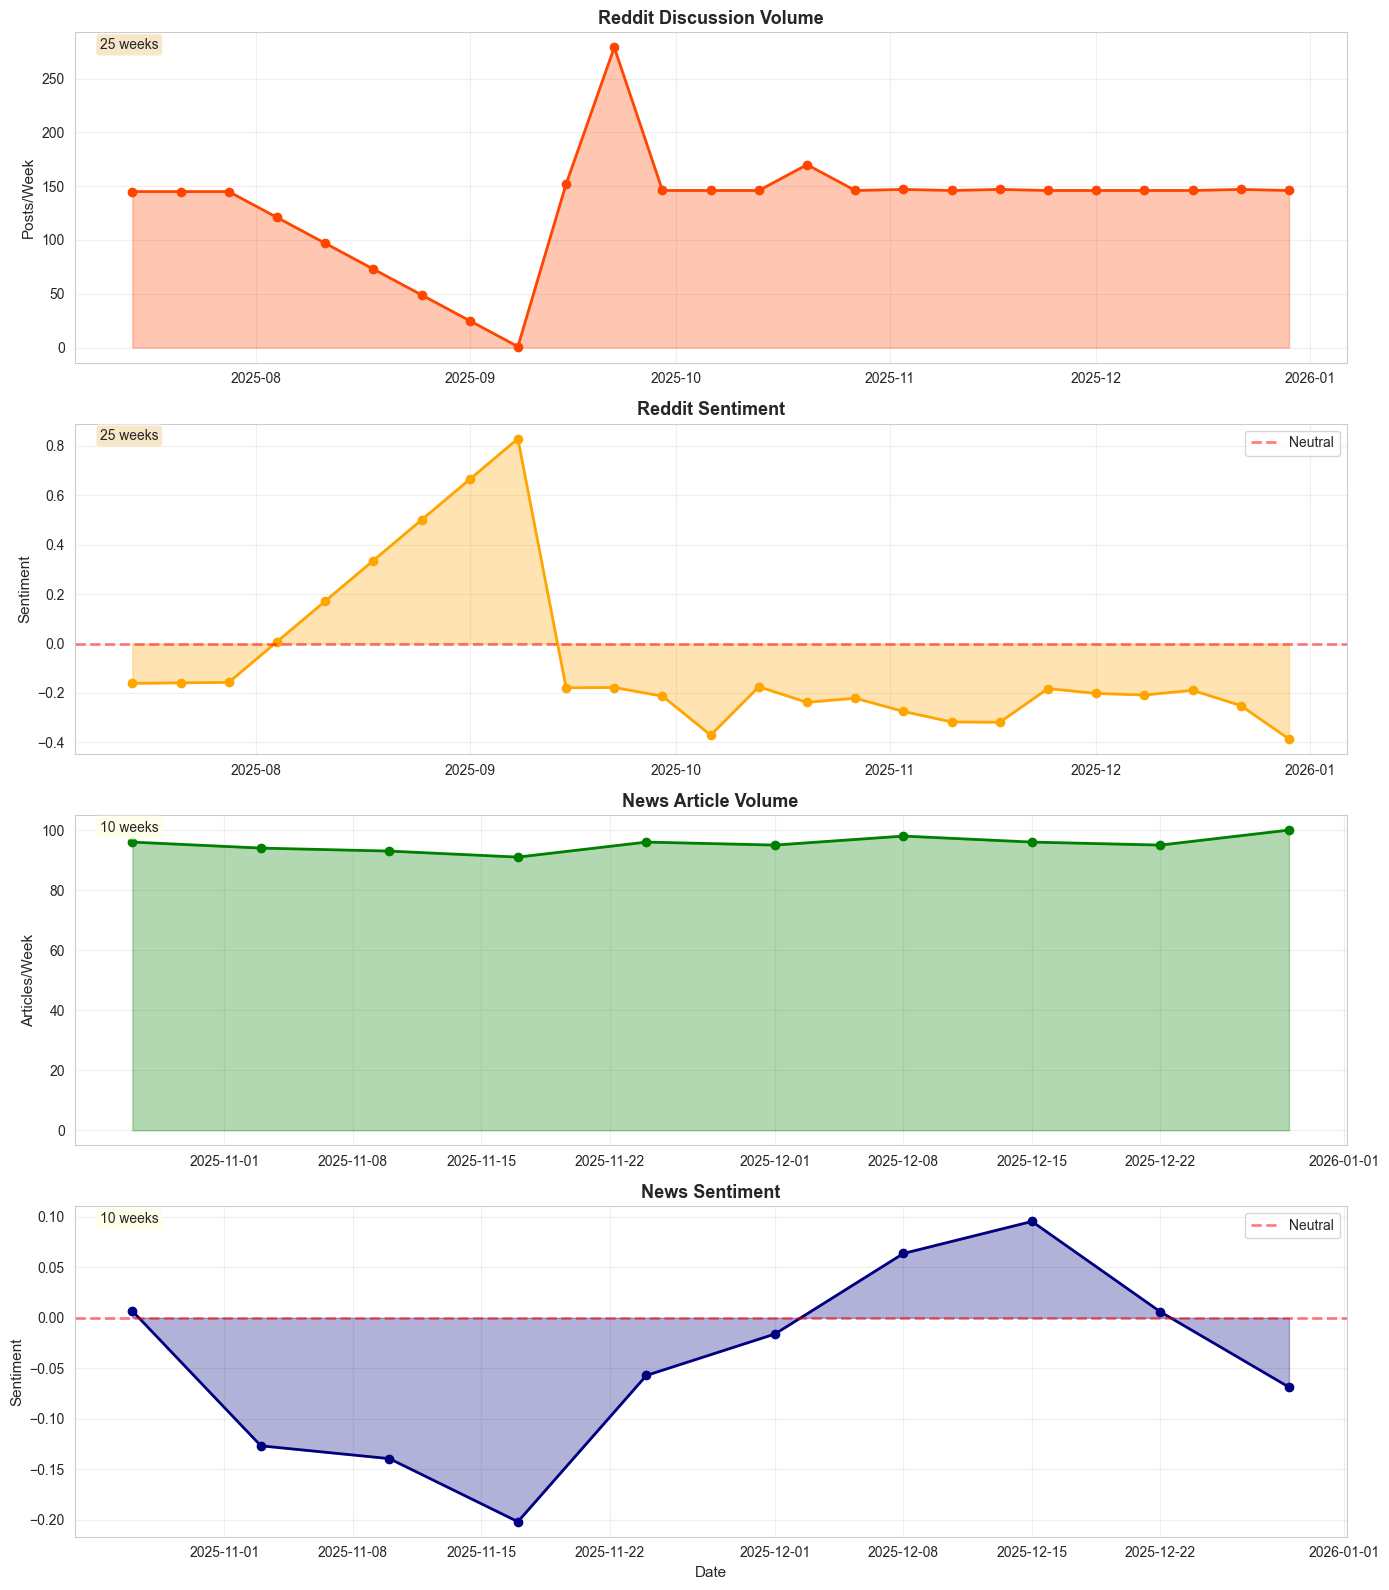

In [10]:
# Compare all 4 Time-Series
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Reddit Volume
axes[0].plot(weekly_reddit['date'], weekly_reddit['volume'], 
             marker='o', linewidth=2, color='#FF4500')
axes[0].fill_between(weekly_reddit['date'], weekly_reddit['volume'], 
                      alpha=0.3, color='#FF4500')
axes[0].set_title('Reddit Discussion Volume', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Posts/Week', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.95, f'{len(weekly_reddit)} weeks', 
             transform=axes[0].transAxes, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Reddit Sentiment
axes[1].plot(weekly_reddit['date'], weekly_reddit['sentiment'], 
             marker='o', linewidth=2, color='orange')
axes[1].fill_between(weekly_reddit['date'], weekly_reddit['sentiment'], 
                      alpha=0.3, color='orange')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Neutral')
axes[1].set_title('Reddit Sentiment', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Sentiment', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right')
axes[1].text(0.02, 0.95, f'{len(weekly_reddit)} weeks', 
             transform=axes[1].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# News Volume
axes[2].plot(weekly_news['date'], weekly_news['volume'], 
             marker='o', linewidth=2, color='green')
axes[2].fill_between(weekly_news['date'], weekly_news['volume'], 
                      alpha=0.3, color='green')
axes[2].set_title('News Article Volume', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Articles/Week', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].text(0.02, 0.95, f'{len(weekly_news)} weeks', 
             transform=axes[2].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# News Sentiment
axes[3].plot(weekly_news['date'], weekly_news['sentiment'], 
             marker='o', linewidth=2, color='navy')
axes[3].fill_between(weekly_news['date'], weekly_news['sentiment'], 
                      alpha=0.3, color='navy')
axes[3].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Neutral')
axes[3].set_title('News Sentiment', fontsize=13, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=11)
axes[3].set_ylabel('Sentiment', fontsize=11)
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='upper right')
axes[3].text(0.02, 0.95, f'{len(weekly_news)} weeks', 
             transform=axes[3].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.show()

# Save plot
fig.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/reddit_news_volume_and_sentiment.png',
    dpi=150,
    bbox_inches='tight'
)

In [11]:
# Summary comparison
print("DATA SUMMARY")

# Reddit Summary
print(f"Reddit:  {len(weekly_reddit)} weeks | "
      f"{weekly_reddit['date'].min().date()} to {weekly_reddit['date'].max().date()}")
print(f"  Volume:    {weekly_reddit['volume'].mean():.1f} ± {weekly_reddit['volume'].std():.1f} posts/week")
print(f"  Sentiment: {weekly_reddit['sentiment'].mean():.3f} ± {weekly_reddit['sentiment'].std():.3f}")

# News Summary
print(f"\nNews:    {len(weekly_news)} weeks | "
      f"{weekly_news['date'].min().date()} to {weekly_news['date'].max().date()}")
print(f"  Volume:    {weekly_news['volume'].mean():.1f} ± {weekly_news['volume'].std():.1f} articles/week")
print(f"  Sentiment: {weekly_news['sentiment'].mean():.3f} ± {weekly_news['sentiment'].std():.3f}")

# Sentiment Comparison Summary
print(f"\nSentiment Comparison:")
reddit_sent_mean = weekly_reddit['sentiment'].mean()
news_sent_mean = weekly_news['sentiment'].mean()
sent_diff = reddit_sent_mean - news_sent_mean
print(f"  Reddit avg:  {reddit_sent_mean:.3f}")
print(f"  News avg:    {news_sent_mean:.3f}")
print(f"  Difference:  {sent_diff:+.3f} ({'Reddit more positive' if sent_diff > 0 else 'News more positive'})")


DATA SUMMARY
Reddit:  25 weeks | 2025-07-14 to 2025-12-29
  Volume:    132.1 ± 52.8 posts/week
  Sentiment: -0.075 ± 0.322

News:    10 weeks | 2025-10-27 to 2025-12-29
  Volume:    95.4 ± 2.5 articles/week
  Sentiment: -0.044 ± 0.093

Sentiment Comparison:
  Reddit avg:  -0.075
  News avg:    -0.044
  Difference:  -0.031 (News more positive)


INFO:analysis.forecasting.forecasting_utils:
Training Prophet model: Reddit Volume
INFO:analysis.forecasting.forecasting_utils:  Training data: 25 observations
INFO:analysis.forecasting.forecasting_utils:  Frequency: weekly (median gap: 7 days)
INFO:analysis.forecasting.forecasting_utils:  Date range: 2025-07-14 00:00:00 to 2025-12-29 00:00:00
INFO:analysis.forecasting.forecasting_utils:  Value range: 1.00 to 279.00
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:analysis.forecasting.forecasting_utils:  Model trained successfully!
INFO:analysis.forecasting.forecasting_utils:
Generating 13-weeks forecast for Reddit Volume...
INFO:analysis.forecasting.forecasting_utils:  Forecast generated: 38 total points
INFO:analysis.forecasting.forecasting_utils:
Forecast Evaluation (In-Sample):
INFO:analysis.forecasting.forecasting_utils:  MAE:      31.025
INFO:analysis.forecasting.fore

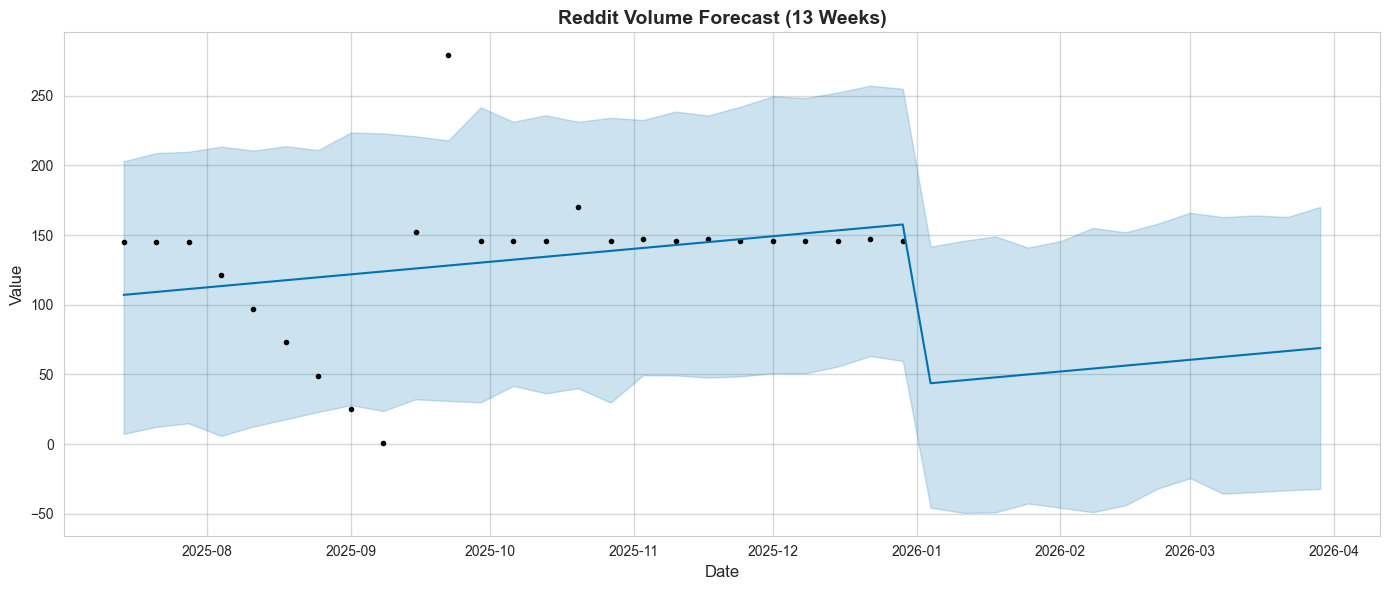

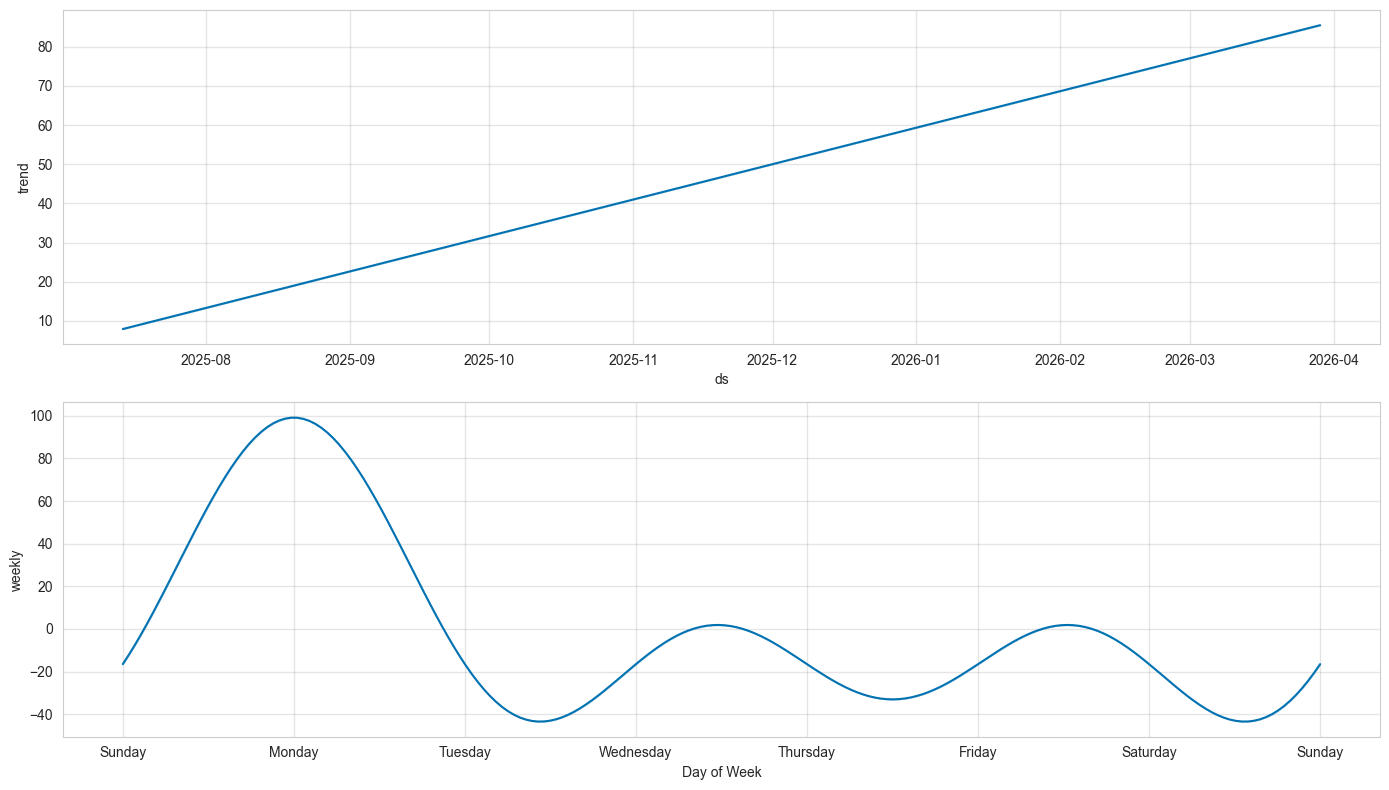

In [12]:
# Train Reddit Volume Model
reddit_volume_model, reddit_volume_data, reddit_vol_freq = train_prophet(
    df=weekly_reddit,
    pred_col='volume',
    model_name='Reddit Volume',
    config=FORECASTING_CONFIG['prophet']
)

# Generate forecast
forecast_periods = FORECASTING_CONFIG['forecast_horizon_weeks']
reddit_volume_forecast = predict_prophet(
    model=reddit_volume_model,
    periods=forecast_periods,
    model_name='Reddit Volume',
    freq=reddit_vol_freq
)

# Plot forecast
fig_forecast = plot_forecast(
    model=reddit_volume_model,
    forecast=reddit_volume_forecast,
    title=f'Reddit Volume Forecast ({forecast_periods} Weeks)',
    figsize=(14, 6)
)

# Save forecast plot
fig_forecast.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/reddit_volume_forecast.png',
    dpi=150,
    bbox_inches='tight'
)

fig_forecast.show()

# Plot components
fig_components = plot_components(
    model=reddit_volume_model,
    forecast=reddit_volume_forecast,
    figsize=(14, 8)
)

# Save components plot
fig_components.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/reddit_volume_components.png',
    dpi=150,
    bbox_inches='tight'
)

fig_components.show()

# Evaluate
reddit_volume_metrics = evaluate_prophet(
    model=reddit_volume_model,
    prophet_df=reddit_volume_data,
    forecast=reddit_volume_forecast,
    use_cv=False
)

INFO:analysis.forecasting.forecasting_utils:
Training Prophet model: Reddit Sentiment
INFO:analysis.forecasting.forecasting_utils:  Training data: 25 observations
INFO:analysis.forecasting.forecasting_utils:  Frequency: weekly (median gap: 7 days)
INFO:analysis.forecasting.forecasting_utils:  Date range: 2025-07-14 00:00:00 to 2025-12-29 00:00:00
INFO:analysis.forecasting.forecasting_utils:  Value range: -0.39 to 0.83
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:analysis.forecasting.forecasting_utils:  Model trained successfully!
INFO:analysis.forecasting.forecasting_utils:
Generating 13-weeks forecast for Reddit Sentiment...
INFO:analysis.forecasting.forecasting_utils:  Forecast generated: 38 total points
INFO:analysis.forecasting.forecasting_utils:
Forecast Evaluation (In-Sample):
INFO:analysis.forecasting.forecasting_utils:  MAE:      0.202
INFO:analysis.forecasting.

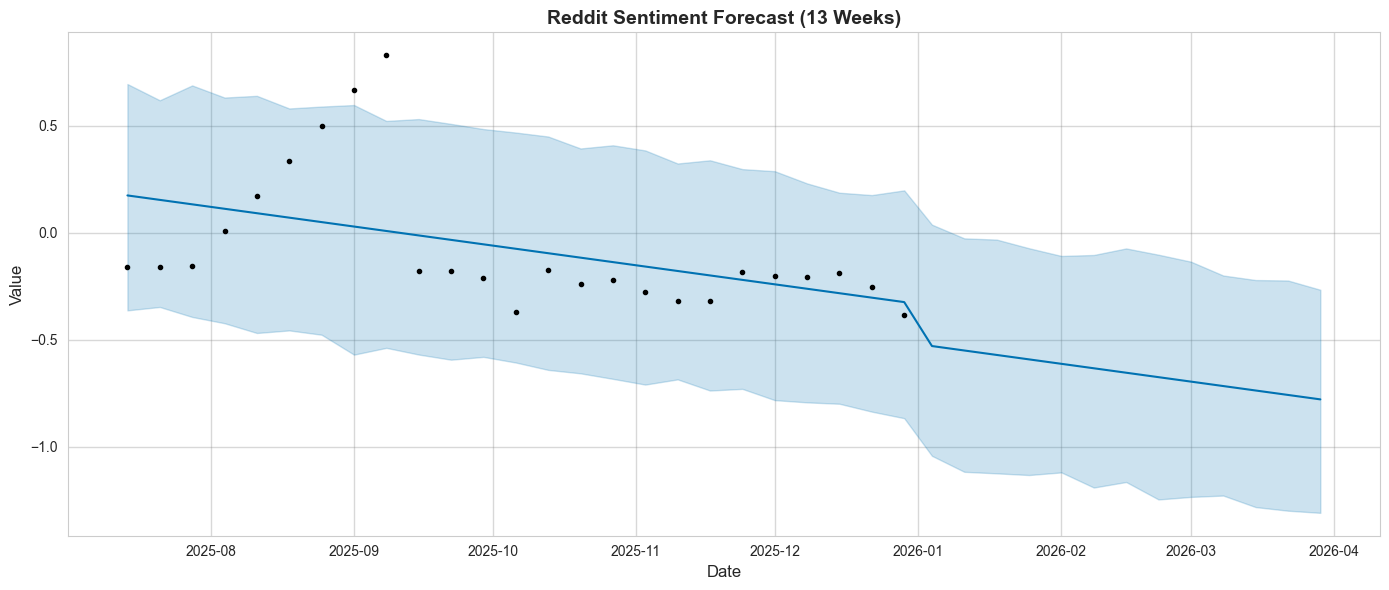

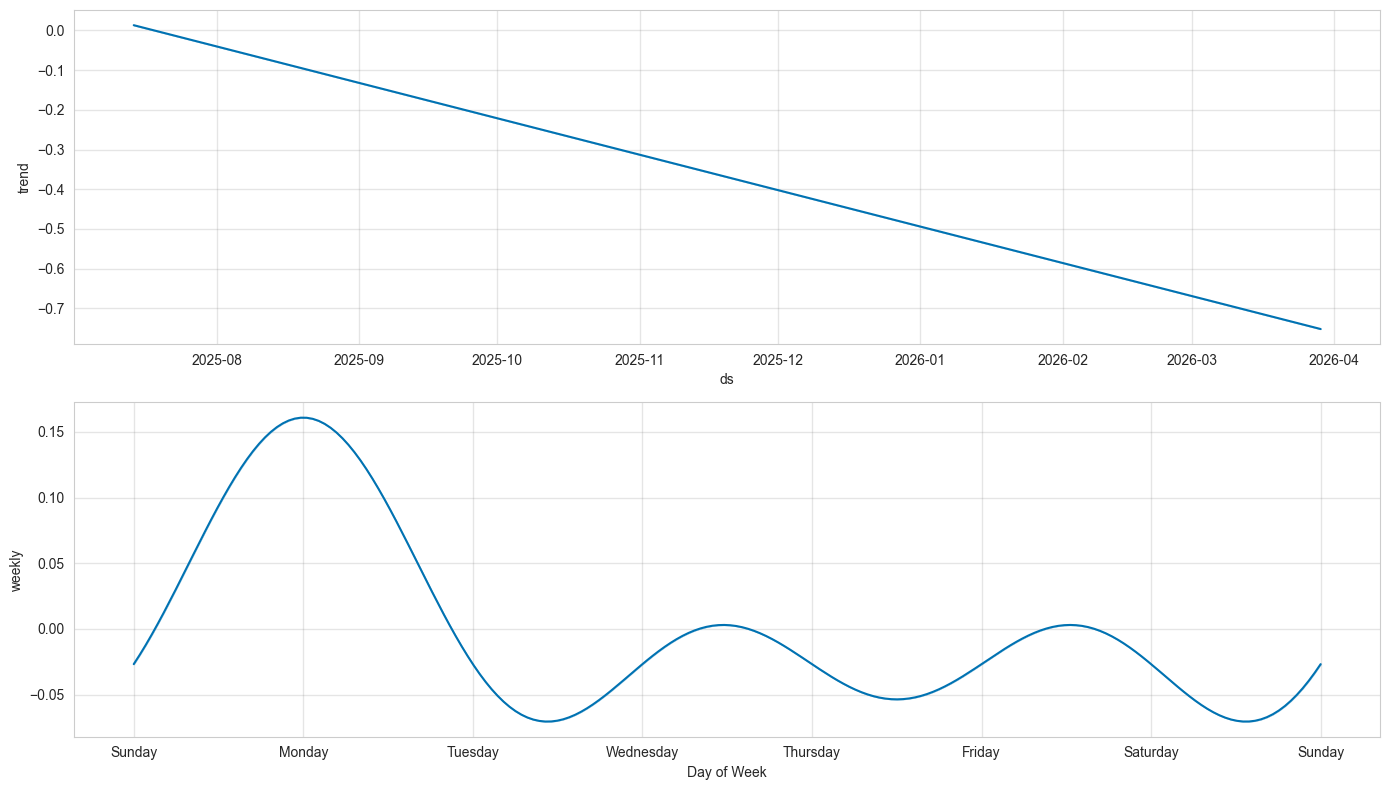

In [13]:
# Train Reddit Sentiment Model
reddit_sentiment_model, reddit_sentiment_data, reddit_sent_freq = train_prophet(
    df=weekly_reddit,
    pred_col='sentiment',
    model_name='Reddit Sentiment',
    config=FORECASTING_CONFIG['prophet']
)

# Generate forecast
reddit_sentiment_forecast = predict_prophet(
    model=reddit_sentiment_model,
    periods=forecast_periods,
    model_name='Reddit Sentiment',
    freq=reddit_sent_freq
)

# Plot forecast
fig_forecast = plot_forecast(
    model=reddit_sentiment_model,
    forecast=reddit_sentiment_forecast,
    title=f'Reddit Sentiment Forecast ({forecast_periods} Weeks)',
    figsize=(14, 6)
)

# Save forecast plot
fig_forecast.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/reddit_sentiment_forecast.png',
    dpi=150,
    bbox_inches='tight'
)

fig_forecast.show()

# Plot components
fig_components = plot_components(
    model=reddit_sentiment_model,
    forecast=reddit_sentiment_forecast,
    figsize=(14, 8)
)

# Save components plot
fig_components.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/reddit_sentiment_components.png',
    dpi=150,
    bbox_inches='tight'
)

fig_components.show()

# Evaluate
reddit_sentiment_metrics = evaluate_prophet(
    model=reddit_sentiment_model,
    prophet_df=reddit_sentiment_data,
    forecast=reddit_sentiment_forecast,
    use_cv=False
)

INFO:analysis.forecasting.forecasting_utils:
Training Prophet model: News Volume
INFO:analysis.forecasting.forecasting_utils:  Training data: 10 observations
INFO:analysis.forecasting.forecasting_utils:  Frequency: weekly (median gap: 7 days)
INFO:analysis.forecasting.forecasting_utils:  Date range: 2025-10-27 00:00:00 to 2025-12-29 00:00:00
INFO:analysis.forecasting.forecasting_utils:  Value range: 91.00 to 100.00
INFO:prophet:n_changepoints greater than number of observations. Using 7.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:analysis.forecasting.forecasting_utils:  Model trained successfully!
INFO:analysis.forecasting.forecasting_utils:
Generating 13-weeks forecast for News Volume...
INFO:analysis.forecasting.forecasting_utils:  Forecast generated: 23 total points
INFO:analysis.forecasting.forecasting_utils:
Forecast Evaluation (In-Sample):
INFO:analysis.forecasting.forecasting_utils:  MAE:      1.800
INFO:analysis.forecasting.forecasti

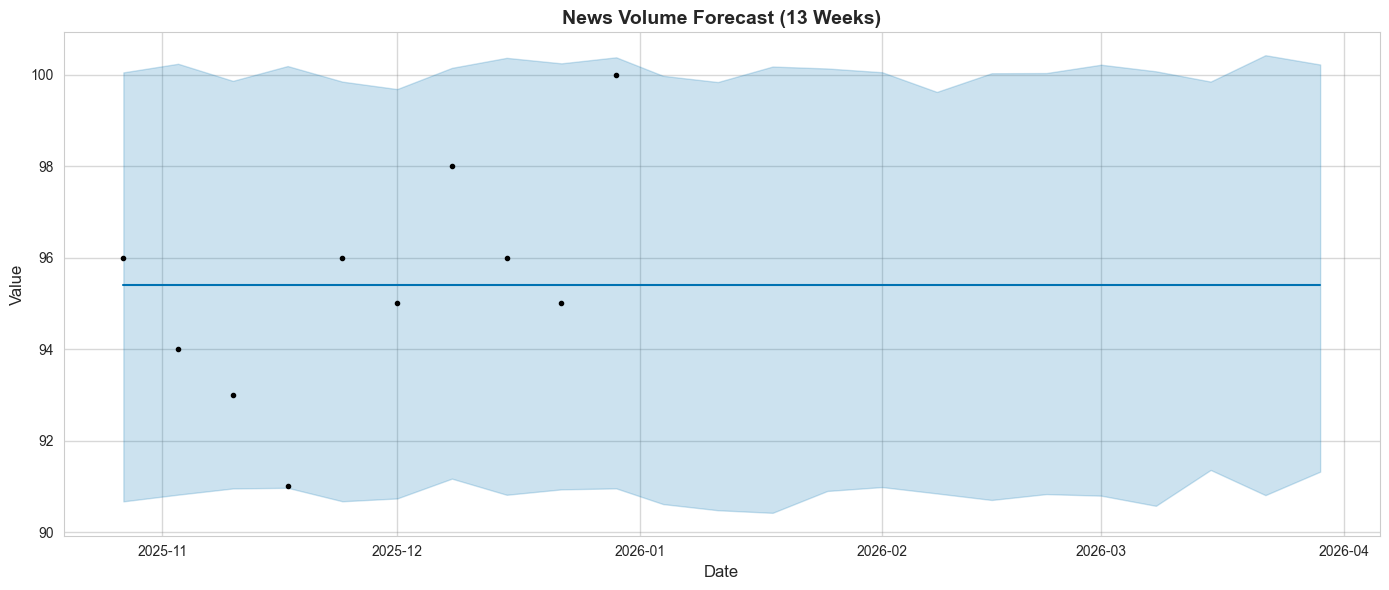

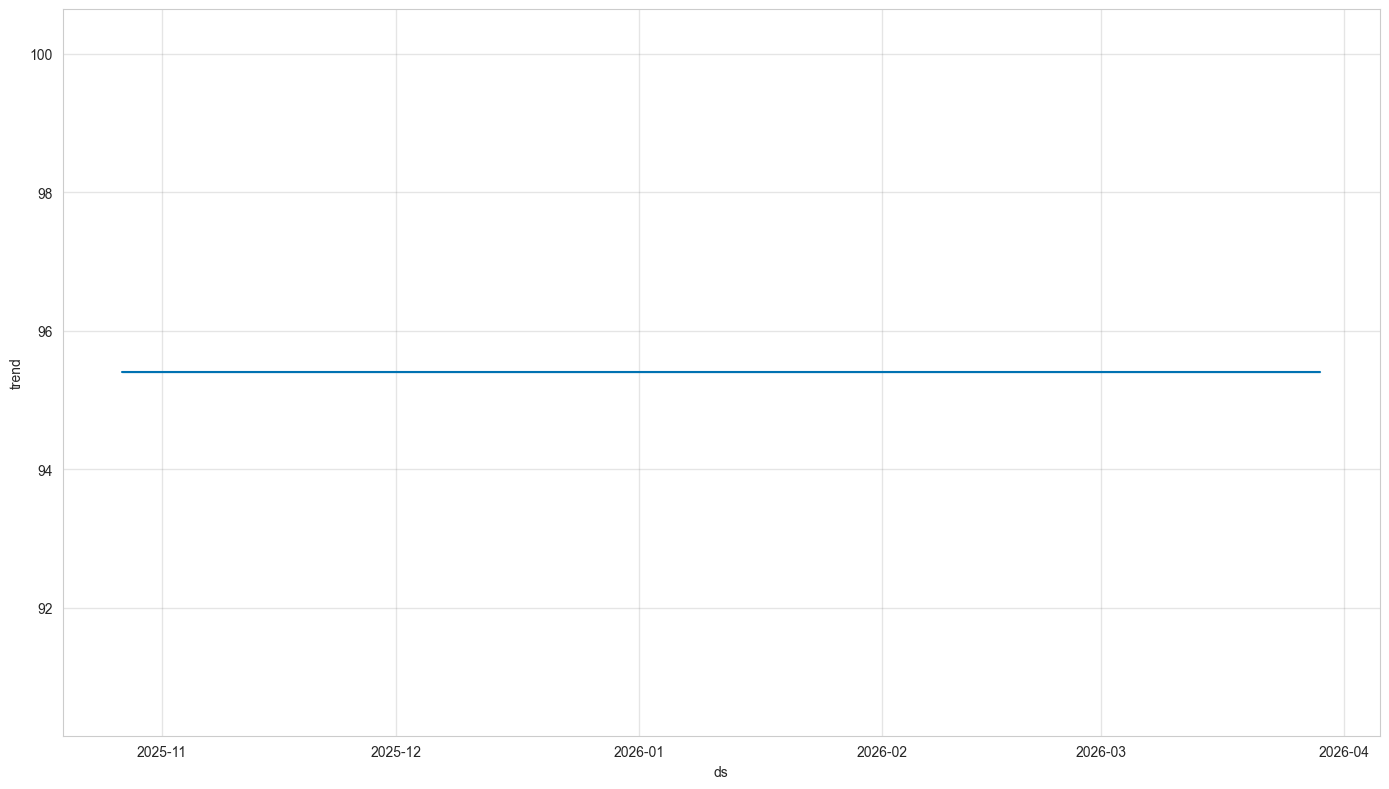

In [14]:
# Train News Volume Model
news_volume_config = FORECASTING_CONFIG['prophet'].copy()
news_volume_config['growth'] = 'flat'
news_volume_config['weekly_seasonality'] = False

news_volume_model, news_volume_data, news_vol_freq = train_prophet(
    df=weekly_news,
    pred_col='volume',
    model_name='News Volume',
    config=news_volume_config
)

# Generate forecast
news_volume_forecast = predict_prophet(
    model=news_volume_model,
    periods=forecast_periods,
    model_name='News Volume',
    freq=news_vol_freq
)

# Plot forecast
fig_forecast = plot_forecast(
    model=news_volume_model,
    forecast=news_volume_forecast,
    title=f'News Volume Forecast ({forecast_periods} Weeks)',
    figsize=(14, 6)
)

# Save forecast plot
fig_forecast.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/news_volume_forecast.png',
    dpi=150,
    bbox_inches='tight'
)

fig_forecast.show()

# Plot components
fig_components = plot_components(
    model=news_volume_model,
    forecast=news_volume_forecast,
    figsize=(14, 8)
)

# Save components plot
fig_components.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/news_volume_components.png',
    dpi=150,
    bbox_inches='tight'
)

fig_components.show()

# Evaluate
news_volume_metrics = evaluate_prophet(
    model=news_volume_model,
    prophet_df=news_volume_data,
    forecast=news_volume_forecast,
    use_cv=False
)

INFO:analysis.forecasting.forecasting_utils:
Training Prophet model: News Sentiment
INFO:analysis.forecasting.forecasting_utils:  Training data: 10 observations
INFO:analysis.forecasting.forecasting_utils:  Frequency: weekly (median gap: 7 days)
INFO:analysis.forecasting.forecasting_utils:  Date range: 2025-10-27 00:00:00 to 2025-12-29 00:00:00
INFO:analysis.forecasting.forecasting_utils:  Value range: -0.20 to 0.10
INFO:prophet:n_changepoints greater than number of observations. Using 7.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:analysis.forecasting.forecasting_utils:  Model trained successfully!
INFO:analysis.forecasting.forecasting_utils:
Generating 13-weeks forecast for News Sentiment...
INFO:analysis.forecasting.forecasting_utils:  Forecast generated: 23 total points
INFO:analysis.forecasting.forecasting_utils:
Forecast Evaluation (In-Sample):
INFO:analysis.forecasting.forecasting_utils:  MAE:      0.065
INFO:analysis.forecasting.forec

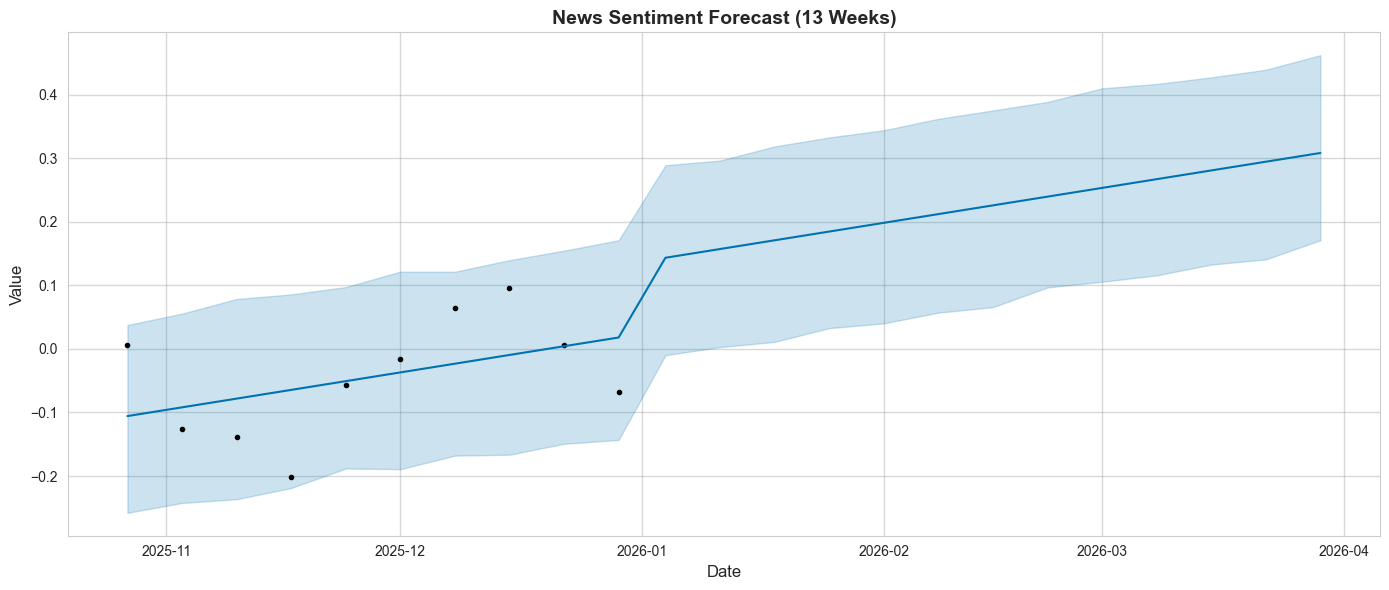

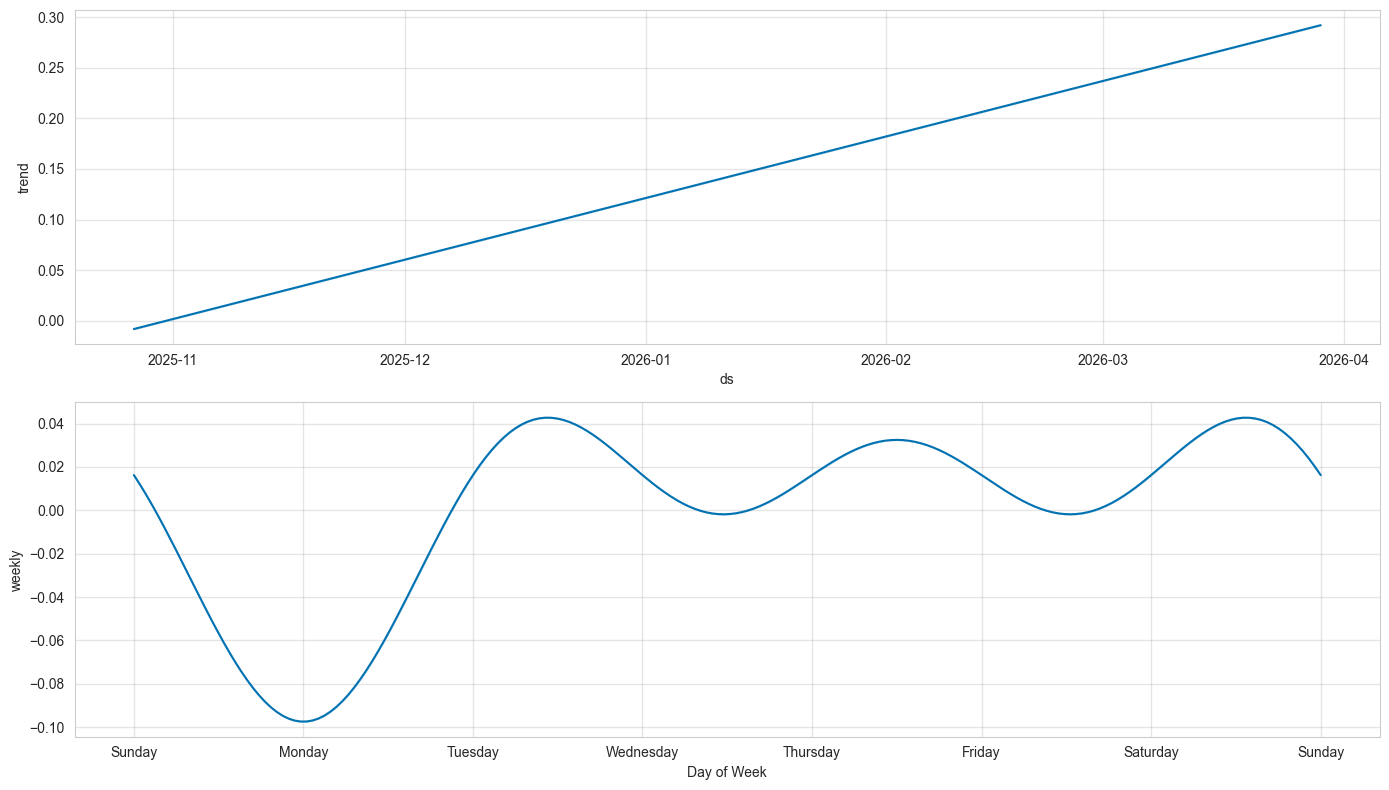

In [15]:
# Train News Sentiment Model
news_sentiment_model, news_sentiment_data, news_sent_freq = train_prophet(
    df=weekly_news,
    pred_col='sentiment',
    model_name='News Sentiment',
    config=FORECASTING_CONFIG['prophet']
)

# Generate forecast
news_sentiment_forecast = predict_prophet(
    model=news_sentiment_model,
    periods=forecast_periods,
    model_name='News Sentiment',
    freq=news_sent_freq
)

# Plot forecast
fig_forecast = plot_forecast(
    model=news_sentiment_model,
    forecast=news_sentiment_forecast,
    title=f'News Sentiment Forecast ({forecast_periods} Weeks)',
    figsize=(14, 6)
)

# Save forecast plot
fig_forecast.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/news_sentiment_forecast.png',
    dpi=150,
    bbox_inches='tight'
)

fig_forecast.show()

# Plot components
fig_components = plot_components(
    model=news_sentiment_model,
    forecast=news_sentiment_forecast,
    figsize=(14, 8)
)

# Save components plot
fig_components.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/news_sentiment_components.png',
    dpi=150,
    bbox_inches='tight'
)

fig_components.show()

# Evaluate
news_sentiment_metrics = evaluate_prophet(
    model=news_sentiment_model,
    prophet_df=news_sentiment_data,
    forecast=news_sentiment_forecast,
    use_cv=False
)

In [16]:
# Extract future predictions
reddit_vol_future = get_future_predictions(
    reddit_volume_forecast, 
    reddit_volume_data,
    forecast_periods
)
reddit_sent_future = get_future_predictions(
    reddit_sentiment_forecast,
    reddit_sentiment_data,
    forecast_periods
)
news_vol_future = get_future_predictions(
    news_volume_forecast,
    news_volume_data,
    forecast_periods
)
news_sent_future = get_future_predictions(
    news_sentiment_forecast,
    news_sentiment_data,
    forecast_periods
)

INFO:analysis.forecasting.forecasting_utils:  Extracted 13 future prediction points
INFO:analysis.forecasting.forecasting_utils:  Future period: 2026-01-04 00:00:00 to 2026-03-29 00:00:00
INFO:analysis.forecasting.forecasting_utils:  Extracted 13 future prediction points
INFO:analysis.forecasting.forecasting_utils:  Future period: 2026-01-04 00:00:00 to 2026-03-29 00:00:00
INFO:analysis.forecasting.forecasting_utils:  Extracted 13 future prediction points
INFO:analysis.forecasting.forecasting_utils:  Future period: 2026-01-04 00:00:00 to 2026-03-29 00:00:00
INFO:analysis.forecasting.forecasting_utils:  Extracted 13 future prediction points
INFO:analysis.forecasting.forecasting_utils:  Future period: 2026-01-04 00:00:00 to 2026-03-29 00:00:00


In [17]:
# Validate future predictions
print("VALIDATING FUTURE PREDICTIONS")

for name, future_df, training_df in [
    ("Reddit Volume", reddit_vol_future, reddit_volume_data),
    ("Reddit Sentiment", reddit_sent_future, reddit_sentiment_data),
    ("News Volume", news_vol_future, news_volume_data),
    ("News Sentiment", news_sent_future, news_sentiment_data)
]:
    last_train = training_df['ds'].max()
    first_pred = future_df['ds'].min()
    last_pred = future_df['ds'].max()
    
    print(f"\n{name}:")
    print(f"  Last training: {last_train.date()}")
    print(f"  First forecast: {first_pred.date()}")
    print(f"  Last forecast: {last_pred.date()}")
    print(f"  Forecast points: {len(future_df)}")
    print(f"  Predicted range: {future_df['yhat'].min():.1f} - {future_df['yhat'].max():.1f}")
    
    # Check if dates make sense
    if first_pred <= last_train:
        print(f"  ERROR: Forecast starts BEFORE training ends!")
    else:
        days_gap = (first_pred - last_train).days
        print(f"  Valid: {days_gap} day gap between training and forecast")

# Use future predictions 
reddit_vol_weekly = reddit_vol_future
reddit_sent_weekly = reddit_sent_future
news_vol_weekly = news_vol_future
news_sent_weekly = news_sent_future

VALIDATING FUTURE PREDICTIONS

Reddit Volume:
  Last training: 2025-12-29
  First forecast: 2026-01-04
  Last forecast: 2026-03-29
  Forecast points: 13
  Predicted range: 43.7 - 68.9
  Valid: 6 day gap between training and forecast

Reddit Sentiment:
  Last training: 2025-12-29
  First forecast: 2026-01-04
  Last forecast: 2026-03-29
  Forecast points: 13
  Predicted range: -0.8 - -0.5
  Valid: 6 day gap between training and forecast

News Volume:
  Last training: 2025-12-29
  First forecast: 2026-01-04
  Last forecast: 2026-03-29
  Forecast points: 13
  Predicted range: 95.4 - 95.4
  Valid: 6 day gap between training and forecast

News Sentiment:
  Last training: 2025-12-29
  First forecast: 2026-01-04
  Last forecast: 2026-03-29
  Forecast points: 13
  Predicted range: 0.1 - 0.3
  Valid: 6 day gap between training and forecast


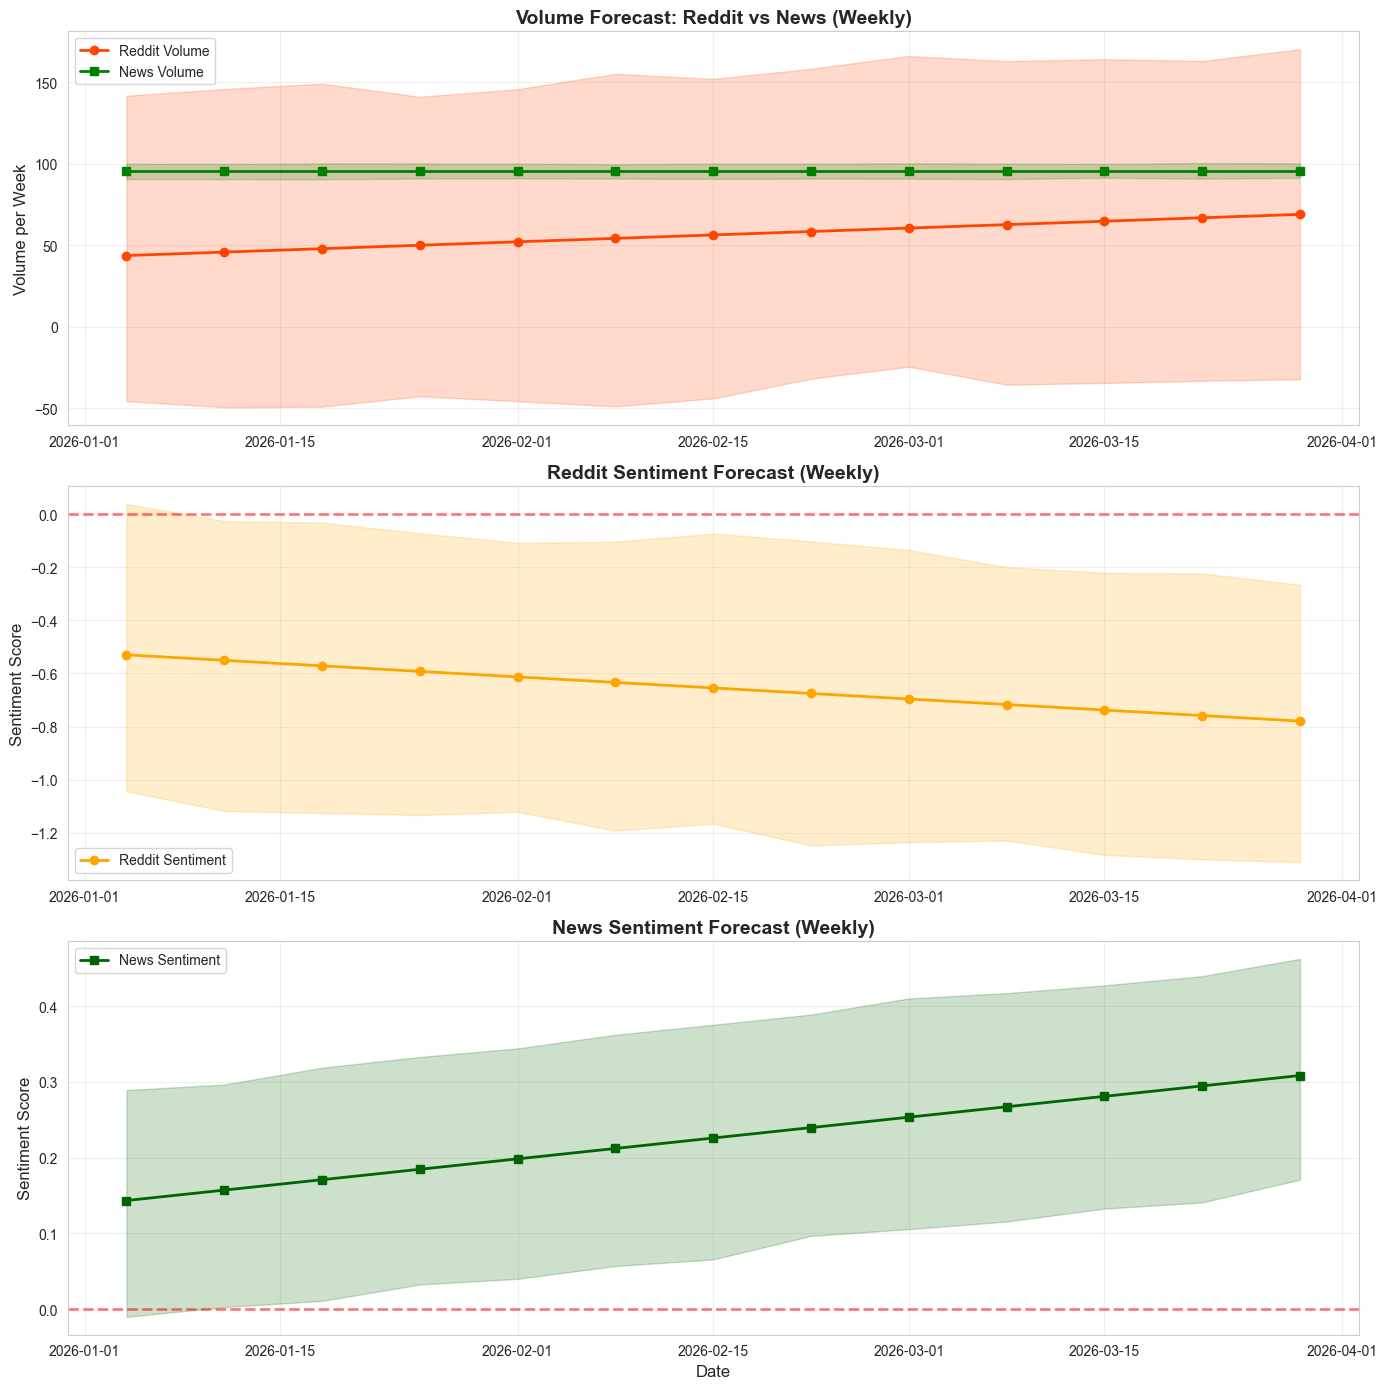

In [18]:
# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Volume comparison
axes[0].plot(reddit_vol_weekly['ds'], reddit_vol_weekly['yhat'], 
             marker='o', linewidth=2, color='#FF4500', label='Reddit Volume')
axes[0].plot(news_vol_weekly['ds'], news_vol_weekly['yhat'], 
             marker='s', linewidth=2, color='green', label='News Volume')
axes[0].fill_between(reddit_vol_weekly['ds'], reddit_vol_weekly['yhat_lower'], 
                      reddit_vol_weekly['yhat_upper'], alpha=0.2, color='#FF4500')
axes[0].fill_between(news_vol_weekly['ds'], news_vol_weekly['yhat_lower'], 
                      news_vol_weekly['yhat_upper'], alpha=0.2, color='green')
axes[0].set_title('Volume Forecast: Reddit vs News (Weekly)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Volume per Week', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reddit sentiment
axes[1].plot(reddit_sent_weekly['ds'], reddit_sent_weekly['yhat'], 
             marker='o', linewidth=2, color='orange', label='Reddit Sentiment')
axes[1].fill_between(reddit_sent_weekly['ds'], reddit_sent_weekly['yhat_lower'], 
                      reddit_sent_weekly['yhat_upper'], alpha=0.2, color='orange')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
axes[1].set_title('Reddit Sentiment Forecast (Weekly)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Sentiment Score', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# News sentiment
axes[2].plot(news_sent_weekly['ds'], news_sent_weekly['yhat'], 
             marker='s', linewidth=2, color='darkgreen', label='News Sentiment')
axes[2].fill_between(news_sent_weekly['ds'], news_sent_weekly['yhat_lower'], 
                      news_sent_weekly['yhat_upper'], alpha=0.2, color='darkgreen')
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
axes[2].set_title('News Sentiment Forecast (Weekly)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Sentiment Score', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save  plot
fig.savefig(
    PROJECT_ROOT / 'analysis/outputs/figures/forecasting/forecast_comparison.png',
    dpi=150,
    bbox_inches='tight'
)

In [19]:
# Calculate insights
reddit_vol_mean = reddit_vol_weekly['yhat'].mean()
news_vol_mean = news_vol_weekly['yhat'].mean()
reddit_sent_mean = reddit_sent_weekly['yhat'].mean()
news_sent_mean = news_sent_weekly['yhat'].mean()

reddit_sent_trend = reddit_sent_weekly['yhat'].iloc[-1] - reddit_sent_weekly['yhat'].iloc[0]
news_sent_trend = news_sent_weekly['yhat'].iloc[-1] - news_sent_weekly['yhat'].iloc[0]

# Print Insights
print(f"FORECAST INSIGHTS (Next {forecast_periods} Weeks)")

print(f"\nVolume Forecasts:")
print(f"  Reddit avg:   {reddit_vol_mean:.1f} posts/week")
print(f"  News avg:     {news_vol_mean:.1f} articles/week")
print(f"  Volume ratio: {reddit_vol_mean/news_vol_mean:.1f}x (Reddit/News)")

print(f"\nSentiment Forecasts:")
print(f"  Reddit avg:   {reddit_sent_mean:.3f}")
print(f"  News avg:     {news_sent_mean:.3f}")
print(f"  Difference:   {reddit_sent_mean - news_sent_mean:+.3f}")

print(f"\nSentiment Trends:")
print(f"  Reddit:  {reddit_sent_trend:+.3f} ({'IMPROVING' if reddit_sent_trend > 0 else 'DECLINING'})")
print(f"  News:    {news_sent_trend:+.3f} ({'IMPROVING' if news_sent_trend > 0 else 'DECLINING'})")

FORECAST INSIGHTS (Next 13 Weeks)

Volume Forecasts:
  Reddit avg:   56.3 posts/week
  News avg:     95.4 articles/week
  Volume ratio: 0.6x (Reddit/News)

Sentiment Forecasts:
  Reddit avg:   -0.654
  News avg:     0.226
  Difference:   -0.880

Sentiment Trends:
  Reddit:  -0.249 (DECLINING)
  News:    +0.165 (IMPROVING)


In [20]:
# Create output directories
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
models_dir = PROJECT_ROOT / 'analysis/models/saved_models/forecasting'
outputs_dir = PROJECT_ROOT / 'analysis/outputs/results/forecasting'

models_dir.mkdir(parents=True, exist_ok=True)
outputs_dir.mkdir(parents=True, exist_ok=True)

In [21]:
# Save Models
# Reddit Volume
reddit_vol_path = models_dir / f'prophet_reddit_volume_{timestamp}.pkl'
with open(reddit_vol_path, 'wb') as f:
    pickle.dump(reddit_volume_model, f)
print(f"✓ {reddit_vol_path.name}")

# Reddit Sentiment
reddit_sent_path = models_dir / f'prophet_reddit_sentiment_{timestamp}.pkl'
with open(reddit_sent_path, 'wb') as f:
    pickle.dump(reddit_sentiment_model, f)
print(f"✓ {reddit_sent_path.name}")

# News Volume
news_vol_path = models_dir / f'prophet_news_volume_{timestamp}.pkl'
with open(news_vol_path, 'wb') as f:
    pickle.dump(news_volume_model, f)
print(f"✓ {news_vol_path.name}")

# News Sentiment
news_sent_path = models_dir / f'prophet_news_sentiment_{timestamp}.pkl'
with open(news_sent_path, 'wb') as f:
    pickle.dump(news_sentiment_model, f)
print(f"✓ {news_sent_path.name}")

✓ prophet_reddit_volume_20260107_005118.pkl
✓ prophet_reddit_sentiment_20260107_005118.pkl
✓ prophet_news_volume_20260107_005118.pkl
✓ prophet_news_sentiment_20260107_005118.pkl


In [22]:
# Save Forecasts
def convert_timestamps(obj):
    """Convert pandas Timestamps to ISO format strings for JSON serialization"""
    if isinstance(obj, pd.Timestamp):
        return obj.isoformat()
    elif isinstance(obj, datetime):
        return obj.isoformat()
    raise TypeError(f"Type {type(obj)} not serializable")

# Prepare forecast data
forecasts_data = {
    'reddit_volume': {
        'predictions': reddit_vol_future.to_dict('records'),
        'metrics': reddit_volume_metrics,
        'training_weeks': len(reddit_volume_data),
        'model_type': 'Prophet',
        'frequency': 'weekly'
    },
    'reddit_sentiment': {
        'predictions': reddit_sent_future.to_dict('records'),
        'metrics': reddit_sentiment_metrics,
        'training_weeks': len(reddit_sentiment_data),
        'model_type': 'Prophet',
        'frequency': 'weekly'
    },
    'news_volume': {
        'predictions': news_vol_future.to_dict('records'),
        'metrics': news_volume_metrics,
        'training_weeks': len(news_volume_data),
        'model_type': 'Prophet (flat growth)',
        'frequency': 'weekly'
    },
    'news_sentiment': {
        'predictions': news_sent_future.to_dict('records'),
        'metrics': news_sentiment_metrics,
        'training_weeks': len(news_sentiment_data),
        'model_type': 'Prophet',
        'frequency': 'weekly'
    },
    'metadata': {
        'forecast_horizon_weeks': forecast_periods,
        'forecast_horizon_days': forecast_periods * 7,
        'training_timestamp': timestamp,
        'prophet_config': FORECASTING_CONFIG['prophet'],
        'data_sources': {
            'reddit': {
                'date_range': f"{weekly_reddit['date'].min().date()} to {weekly_reddit['date'].max().date()}",
                'weeks': len(weekly_reddit)
            },
            'news': {
                'date_range': f"{weekly_news['date'].min().date()} to {weekly_news['date'].max().date()}",
                'weeks': len(weekly_news)
            }
        }
    }
}

# Save with timestamp
forecasts_path = outputs_dir / f'forecasts_{timestamp}.json'
with open(forecasts_path, 'w') as f:
    json.dump(forecasts_data, f, indent=2, default=convert_timestamps)
print(f"✓ {forecasts_path.name}")

# Save as "latest" for easy API access
latest_path = outputs_dir / 'latest_forecasts.json'
with open(latest_path, 'w') as f:
    json.dump(forecasts_data, f, indent=2, default=convert_timestamps)
print(f"✓ latest_forecasts.json (for API)")

✓ forecasts_20260107_005118.json
✓ latest_forecasts.json (for API)


In [23]:
# Save Weekly Aggregated Data
weekly_reddit.to_csv(outputs_dir / f'weekly_reddit_{timestamp}.csv', index=False)
print(f"✓ weekly_reddit_{timestamp}.csv")

weekly_news.to_csv(outputs_dir / f'weekly_news_{timestamp}.csv', index=False)
print(f"✓ weekly_news_{timestamp}.csv")

✓ weekly_reddit_20260107_005118.csv
✓ weekly_news_20260107_005118.csv
